In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.optimize as optimize
import pymc3 as pm
import arviz as az
import theano.tensor as tt

import networkx as nx

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set_theme(style='ticks', context='paper', font_scale=0.8);

%reload_ext watermark
%watermark -a "Mathieu Baltussen" -d -t -u -v -iv

Author: Mathieu Baltussen

Last updated: 2022-04-11 14:11:42

Python implementation: CPython
Python version       : 3.9.5
IPython version      : 8.0.1

matplotlib: 3.4.2
pymc3     : 3.11.2
pandas    : 1.2.4
networkx  : 2.5.1
numpy     : 1.22.2
arviz     : 0.11.2
seaborn   : 0.11.1
theano    : 1.1.2
scipy     : 1.6.2



In [2]:
data = pd.read_csv("../data/CEKS33.csv")
kf = 0.125  # minute^-1
E = 0.012
data = data.assign(kf=kf, Tr=E)
data_1 = data[data.AAA == 0]
data_2 = data[data.AAA != 0]


In [3]:
with pm.Model() as model_1:
    k_cat = pm.Uniform("k_cat", 0, 500)
    K_M = pm.Uniform("K_M", 0, 500)
    K_I = pm.Uniform("K_I", 1000, 10000)
    sigma = pm.Exponential("sigma", 10)

    S_in = data_1["R"].values
    I_in = data_1["AAA"].values
    P_obs = data_1["AMC"].values
    S_obs = (
        S_in - P_obs
    )  # Substrate concentration inside reactor determined via stoichiometric conservation at steady-state
    E = data_1["Tr"].values
    kf = data_1["kf"].values

    # Inference of probabilistic model at steady-state conditions
    P = pm.Normal(
        "obs",
        mu=k_cat * E * S_obs / (kf * (K_M + S_obs * (1 + I_in / K_I))),
        sigma=sigma,
        observed=P_obs,
    )
    idata_1 = pm.sample(
        1000,
        tune=1000,
        cores=4,
        step=pm.NUTS(target_accept=0.95),
        return_inferencedata=True,
    )

with pm.Model() as model_2:
    k_cat = pm.Uniform("k_cat", 0, 500)
    K_M = pm.Uniform("K_M", 0, 500)
    K_I = pm.Uniform("K_I", 1000, 10000)
    sigma = pm.Exponential("sigma", 10)

    S_in = data_2["R"].values
    I_in = data_2["AAA"].values
    P_obs = data_2["AMC"].values
    S_obs = (
        S_in - P_obs
    )  # Substrate concentration inside reactor determined via stoichiometric conservation at steady-state
    E = data_2["Tr"].values
    kf = data_2["kf"].values

    # Inference of probabilistic model at steady-state conditions
    P = pm.Normal(
        "obs",
        mu=k_cat * E * S_obs / (kf * (K_M + S_obs * (1 + I_in / K_I))),
        sigma=sigma,
        observed=P_obs,
    )
    idata_2 = pm.sample(
        1000,
        tune=1000,
        cores=4,
        step=pm.NUTS(target_accept=0.95),
        return_inferencedata=True,
    )

with pm.Model() as model:
    k_cat = pm.Uniform("k_cat", 0, 500)
    K_M = pm.Uniform("K_M", 0, 500)
    K_I = pm.Uniform("K_I", 1000, 10000)
    sigma = pm.Exponential("sigma", 10)

    S_in = data["R"].values
    I_in = data["AAA"].values
    P_obs = data["AMC"].values
    S_obs = (
        S_in - P_obs
    )  # Substrate concentration inside reactor determined via stoichiometric conservation at steady-state
    E = data["Tr"].values
    kf = data["kf"].values

    # Inference of probabilistic model at steady-state conditions
    P = pm.Normal(
        "obs",
        mu=k_cat * E * S_obs / (kf * (K_M + S_obs * (1 + I_in / K_I))),
        sigma=sigma,
        observed=P_obs,
    )
    idata = pm.sample(
        1000,
        tune=1000,
        cores=4,
        step=pm.NUTS(target_accept=0.95),
        return_inferencedata=True,
    )


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, K_I, K_M, k_cat]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, K_I, K_M, k_cat]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, K_I, K_M, k_cat]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [4]:
posterior_df_1 = idata_1.to_dataframe(["posterior"])
posterior_df_2 = idata_2.to_dataframe(["posterior"])
posterior_df = idata.to_dataframe(["posterior"])

with model_1:
    post_pred_1 = pm.sample_posterior_predictive(
        idata_1, var_names=["obs", "k_cat", "K_M", "K_I", "sigma"]
    )
posterior_df_1 = pd.DataFrame(
    {
        "k_cat": post_pred_1["k_cat"],
        "K_M": post_pred_1["K_M"],
        "K_I": post_pred_1["K_I"],
        "sigma": post_pred_1["sigma"],
    }
)
with model_2:
    post_pred_2 = pm.sample_posterior_predictive(
        idata_2, var_names=["obs", "k_cat", "K_M", "K_I", "sigma"]
    )
posterior_df_2 = pd.DataFrame(
    {
        "k_cat": post_pred_2["k_cat"],
        "K_M": post_pred_2["K_M"],
        "K_I": post_pred_2["K_I"],
        "sigma": post_pred_2["sigma"],
    }
)
with model:
    post_pred = pm.sample_posterior_predictive(
        idata, var_names=["obs", "k_cat", "K_M", "K_I", "sigma"]
    )
posterior_df = pd.DataFrame(
    {
        "k_cat": post_pred["k_cat"],
        "K_M": post_pred["K_M"],
        "K_I": post_pred["K_I"],
        "sigma": post_pred["sigma"],
    }
)


In [5]:


left = nx.bipartite.sets(model_graph)[0]
pos = nx.bipartite_layout(model_graph, list(left)[::-1], scale=0.8)
print(pos)

pos = {
    "$\\mathcal{L}_{2}$": np.array([0.25, 0.25]),
    "$\\mathcal{L}_{1}$": np.array([0.25, 0.75]),
    "$k_{cat}$": np.array([0.75, 0.7]),
    "$K_M$": np.array([0.75, 0.5]),
    "$K_I$": np.array([0.75, 0.2]),
}

fig, ax = plt.subplots(constrained_layout=True)

with sns.color_palette("deep"):
    nx.draw(
        model_graph,
        pos=pos,
        ax=ax,
        with_labels=True,
        node_size=2000,
        node_color=["C0", "lightgrey", "lightgrey", "C3", "lightgrey"],
        width=2,
        edgecolors="black",
        arrowstyle="-|>",
        arrowsize=6,
        connectionstyle="arc,armB=-15",
    )


NameError: name 'model_graph' is not defined

In [6]:
def plot_ridgeplots(fig, gs, n_plots, data, start_color=0):
    pal = sns.cubehelix_palette(n_plots, start=start_color, rot=-.2, dark=0.4, light=0.9)
    axes = [fig.add_subplot(gs[i,0]) for i in range(n_plots)]

    for i in range(n_plots):
        sns.kdeplot(data[i], ax=axes[i], fill=True, clip_on=True, alpha=0.6, color=pal[i])
        sns.kdeplot(data[i], ax=axes[i], fill=False, clip_on=True, color="black", lw=.2)

    # y_max = max(max(ax.get_yticks()) for ax in axes)*1.1
    x_min, x_max = min(axes[-1].get_xticks()),  max(axes[-1].get_xticks())
    for i, ax in enumerate(axes):
        # ax.set_ylim(0, y_max)
        ymax = max(ax.get_yticks())*(n_plots - i)
        ax.set_ylim(0)
        ax.set_xlim(x_min, x_max)
        ax.patch.set_alpha(0)

    for ax in axes[:-1]:
        ax.axis("off")
        sns.despine(ax=ax, left=True, bottom=True)

    axes[-1].set_yticks([])
    axes[-1].set_ylabel("")
    sns.despine(ax=axes[-1], left=True)

    return axes, pal

In [7]:
palette = sns.cubehelix_palette(3, start=0.4, rot=-.2, dark=0.4, light=0.9)
palette

[[0.8785578419340125, 0.9014144832192498, 0.9687173115546507],
 [0.6406706030956623, 0.622799643084166, 0.8302502287527784],
 [0.4428111826648146, 0.3448837880001888, 0.5788669999260483]]

/home/mathieu/anaconda3/envs/phd/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1061: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)
/home/mathieu/anaconda3/envs/phd/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


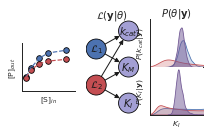

In [8]:
model_graph = nx.DiGraph()
model_graph.add_edge(r"$\mathcal{L}_{1}$", r"$k_{cat}$")
model_graph.add_edge(r"$\mathcal{L}_{1}$", r"$K_M$")
model_graph.add_edge(r"$\mathcal{L}_{2}$", r"$k_{cat}$")
model_graph.add_edge(r"$\mathcal{L}_{2}$", r"$K_M$")
model_graph.add_edge(r"$\mathcal{L}_{2}$", r"$K_I$")
pos = {
    "$\\mathcal{L}_{2}$": np.array([0.33, 0.425]),
    "$\\mathcal{L}_{1}$": np.array([0.33, 0.575]),
    "$k_{cat}$": np.array([0.66, 0.65]),
    "$K_M$": np.array([0.66, 0.5]),
    "$K_I$": np.array([0.66, 0.35]),
}


fig = plt.figure(figsize=(3.25, 1.75), constrained_layout=True)

gs = fig.add_gridspec(4, 3, wspace=0.2, hspace=0.0)

# gs.subplots()


ax_1 = fig.add_subplot(gs[1:3, 0])
ax_1.scatter(data_1.R, data_1.AMC, ec="black", fc="C0", label=r"[I]=0 $\mu M$", s=32)
ax_1.scatter(data_2.R, data_2.AMC, ec="black", fc="C3", label=r"[I]=1500 $\mu M$", s=32)
ax_1.plot(data_1.R, data_1.AMC, "--", c="C0")
ax_1.plot(data_2.R, data_2.AMC, "--", c="C3")
# ax_1.legend()
ax_1.set_xlim(0, 600)
ax_1.set_ylim(0, 9)
# ax_1.text(-0.18, 0.95, 'A', transform=ax_1.transAxes, weight="bold", size=10)
ax_1.set_xlabel(r"$[$S$]_{in}$")
ax_1.set_ylabel(r"$[$P$]_{out}$")
ax_1.set_xticks([])
ax_1.set_yticks([])
sns.despine(ax=ax_1)
ax_1.margins(y=-0.3)

ax_2 = fig.add_subplot(gs[:, 1])

with sns.color_palette("deep"):
    nx.draw(
        model_graph,
        pos=pos,
        ax=ax_2,
        with_labels=True,
        node_size=400,
        node_color=["C0", palette[1], palette[1], "C3", palette[1]],
        width=1,
        edgecolors="black",
        arrowstyle="-|>",
        arrowsize=9,
        connectionstyle="arc",
        font_size=10
    )
    ax_2.margins(x=0.25, y=0.1)

    ax_3 = fig.add_subplot(gs[0:2, 2:])

    sns.kdeplot(posterior_df_1["k_cat"], ax=ax_3, fill=True, color="C0")
    sns.kdeplot(posterior_df_2["k_cat"], ax=ax_3, fill=True, color="C3")
    sns.kdeplot(posterior_df["k_cat"], ax=ax_3, fill=True, color=palette[2], alpha=0.5)
    sns.despine(ax=ax_3)
    ax_3.set_xlim(75, 120)
    ax_3.set_ylabel(r"$P(k_{cat}|\mathbf{y})$")
    ax_3.set_xlabel(r"$k_{cat}$")
    ax_3.set_xticks([])
    ax_3.set_yticks([])


    # gs_rp = gs[2:, 2].subgridspec(3,1, hspace=-0.1)
    # axes, pal = plot_ridgeplots(fig, gs_rp, 3, [
    #                                             posterior_df_1['K_I'], 
    #                                             posterior_df_2['K_I'],
    #                                             posterior_df['K_I']], 
    #                             start_color=0.4
    #                             )

    ax_4 = fig.add_subplot(gs[2:4, 2])

    sns.kdeplot(posterior_df_1["K_I"], ax=ax_4, fill=True, color="C0")
    sns.kdeplot(posterior_df_2["K_I"], ax=ax_4, fill=True, color="C3")
    sns.kdeplot(posterior_df["K_I"], ax=ax_4, fill=True, color=palette[2], alpha=0.5)
    sns.despine(ax=ax_4)
    ax_4.set_xlim(0, 8000)
    ax_4.set_ylabel(r"$P(K_{I}|\mathbf{y})$")
    ax_4.set_xlabel(r"$K_{I}$")
    ax_4.set_xticks([])
    ax_4.set_yticks([])

# ax_0 = fig.add_subplot(gs[0, 0])
# sns.despine(ax=ax_0, left=True, bottom=True)
ax_1.text(0.5, 2.25, r"$\mathbf{y}$", transform=ax_1.transAxes, ha='center', fontsize=10, va='center', weight='bold', in_layout=False)
ax_2.text(0.5, 1.05, r"$\mathcal{L}(\mathbf{y}|\theta)$", transform=ax_2.transAxes, fontsize=10, ha='center', va='center', weight='bold', in_layout=False)
ax_3.margins(y=0.2)
ax_3.text(0.5, 1.13, r"$P(\theta|\mathbf{y})$", transform=ax_3.transAxes, ha='center', fontsize=10,  va='center', weight='bold', in_layout=True)

# plt.savefig("../figures/fig_toc.svg", dpi=300)
plt.show()
